# Проведение A/B теста в крупном интернет магазине

**Цель проекта:** необходимо приоритизировать гипотезы, запустить A/B-тест и проанализировать результат.

**Исходные данные:**
- Гипотезы по увеличению выручки интернет-магазина.
- Заказы и визиты пользователей.

**Оглавление**
<a id='section_id5'></a>
1. [Загрузка и предобработка данных](#section_id1)
2. [Приоритизация гипотез](#section_id2)
3. [Анализ A/B теста](#section_id3)
4. [Результаты исследования](#section_id4)

## Загрузка и предобработка данных
<a id='section_id1'></a>

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import scipy.stats as stats
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()
from collections import Counter

In [2]:
# установим максимальную ширину колонки, чтобы влезли названия гипотез
pd.options.display.max_colwidth = 100

In [3]:
pd.options.display.float_format = '{:,.3f}'.format # установим удобный формат отображения чисел

In [4]:
# загружаем имеющиеся данные
hypothesis, orders, visitors = (
    pd.read_csv('datasets/hypothesis.csv'), # гипотезы
    pd.read_csv('datasets/orders.csv'), # заказы
    pd.read_csv('datasets/visitors.csv') # визиты
)

### Обзор данных

In [5]:
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [6]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


In [7]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [10]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


### Предобработка данных
- В таблице hypothesis приведем наименование колонок к нижнему регистру.
- В таблице orders колонку date переведем в формат даты.
- В таблице visitors колонку date переведем в формат даты. 

In [11]:
hypothesis.columns = hypothesis.columns.str.lower() # переводим наименования колонок в нижний регистр
hypothesis.info() # проверим, что изменения произошли

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 492.0+ bytes


In [12]:
print(hypothesis.duplicated().sum())

0


In [13]:
# изменим тип данных времени заказа на формат даты, приведем наименования колонок в нижний регистр
# и выполним проверку
orders['date'] = pd.to_datetime(orders['date'])
orders.columns = orders.columns.str.lower() 
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [14]:
print(orders.duplicated().sum())

0


In [15]:
# изменим тип данных времени визита на формат даты и выполним проверку
visitors['date'] = pd.to_datetime(visitors['date'])
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [16]:
print(visitors.duplicated().sum())

0


**Выводы:**
- Привели наименования колонок к нижнему регистру в таблицах hypothesis и orders.
- Изменили формат колонок с датой на datetime в таблицах orders и visitors.
- Проверили все таблицы на наличие явных дубликатов.

### Проверка распределения пользователей по группам и периода тестирования

In [17]:
print('Количество уникальных пользователей:', len(orders['visitorid'].unique()))  # считаем кол-во уникальных пользователей
visitors_a = orders.query('group == "A"')['visitorid'].unique()
visitors_b = orders.query('group == "B"')['visitorid'].unique()
print('Количество уникальных пользователей в группе A:', len(visitors_a))
print('Количество уникальных пользователей в группе B:', len(visitors_b))

Количество уникальных пользователей: 1031
Количество уникальных пользователей в группе A: 503
Количество уникальных пользователей в группе B: 586


In [18]:
common_items = list((Counter(visitors_a) & Counter(visitors_b)).elements())
print('Число пользователей в обоих группах:', len(common_items))

Число пользователей в обоих группах: 58


In [19]:
# убираем из теста тех пользователей, которые попали в обе группы
orders = orders[~orders['visitorid'].isin(common_items)]

In [20]:
# проверяем, что число уникальных пользователей уменьшилось на 58
print('Количество уникальных пользователей:', len(orders['visitorid'].unique()))  # считаем кол-во уникальных пользователей

Количество уникальных пользователей: 973


In [21]:
print('Группы для проведения теста:', orders.group.unique())
print('Дата начала проведения теста в группе A:', orders.query('group == "A"').date.min())
print('Дата начала проведения теста в группе B:', orders.query('group == "B"').date.min())
print('Дата окончания проведения теста в группе A:', orders.query('group == "A"').date.min())
print('Дата окончания проведения теста в группе B:', orders.query('group == "B"').date.min())

Группы для проведения теста: ['B' 'A']
Дата начала проведения теста в группе A: 2019-08-01 00:00:00
Дата начала проведения теста в группе B: 2019-08-01 00:00:00
Дата окончания проведения теста в группе A: 2019-08-01 00:00:00
Дата окончания проведения теста в группе B: 2019-08-01 00:00:00


**Выводы:**
- Даты начала и окончания теста совпадают в обоих группах.
- Всего выделено две группы для анализа.
- Данные по 58 пользователям, которые попали в обе группы, были исключены.

[Оглавление](#section_id5)

## Приоритизация гипотез
<a id='section_id2'></a>

In [22]:
# добавим колонки ICE и RICE для дальнейшей приритизации гипотез
hypothesis['ice'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']
hypothesis['rice'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']

`ICE`

In [23]:
hypothesis.sort_values(by='ice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200,16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333,40.000
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200,112.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3,8.000,40.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3,7.000,56.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000,4.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333,4.000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125,9.000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000,3.000


`RICE`

In [24]:
hypothesis.sort_values(by='rice', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ice,rice
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200,112.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3,7.000,56.000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333,40.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3,8.000,40.000
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200,16.200
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125,9.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000,4.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333,4.000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000,3.000


**Выводы:**
- По фреймворку ICE приоритетными являются гипотезы 8, 0, 7.
- По фреймворку RICE приоритетными являются гипотезы 7, 2, 0.
- Приоритет изменился, так как фреймворк RICE учитывает охват пользователей. У гипотезы 7 этот показатель составляет 10, у гипотезы 8 только 1. В связи с этим и изменилась приоритетность.

[Оглавление](#section_id5)

## Анализ A/B теста
<a id='section_id3'></a>

In [25]:
# создаем массив уникальных пар дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates()

In [26]:
# получаем агрегированные кумулятивные по дням данные о заказах
ordersAggregated = datesGroups\
    .apply(lambda x:
           orders[np.logical_and(orders['date'] <= x['date'],
                                 orders['group'] == x['group'])]\
    .agg({
        'date' : 'max',
        'group': 'max',
        'transactionid' : 'nunique',
        'visitorid' : 'nunique',
        'revenue' : 'sum'
        }), axis=1)\
    .sort_values(by=['date','group'])

In [27]:
# получаем агрегированные кумулятивные по дням данные о посетителях
visitorsAggregated = datesGroups\
    .apply(lambda x:
           visitors[np.logical_and(visitors['date'] <= x['date'],
                                   visitors['group'] == x['group'])]\
    .agg({
        'date' : 'max',
        'group' : 'max',
        'visitors' : 'sum'
        }), axis=1)\
    .sort_values(by=['date', 'group'])

In [28]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated,
                                        left_on=['date','group'],
                                        right_on=['date','group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [29]:
print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845


In [30]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе A

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A']\
    [['date','revenue','orders']]


In [31]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B']\
    [['date','revenue','orders']]


In [32]:
cumulativeRevenueB.head()

,date,revenue,orders
1,2019-08-01,59758,17
3,2019-08-02,221801,40
5,2019-08-03,288850,54
7,2019-08-04,385740,68
9,2019-08-05,475648,89


### График кумулятивной выручки по группам

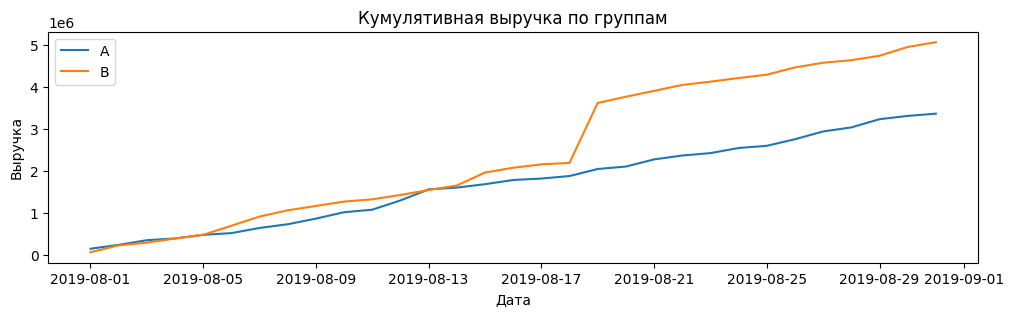

In [33]:
# Строим график выручки группы A и B
plt.figure(figsize=(12, 3))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend()
plt.show()

**Выводы:**
- Выручка растет на протяжении всего теста.
- На графике группы B есть сильный всплеск. Это может говорить либо о резком росте числа заказов, либо о наличии крупной покупки.

### График кумулятивного среднего чека по группам

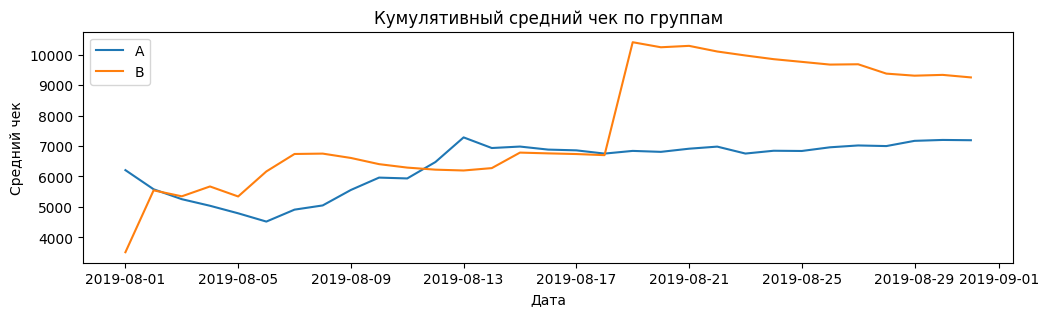

In [34]:
# Строим график среднего чека группы A и B
plt.figure(figsize=(12, 3))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label = 'A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label = 'B')
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.legend()
plt.show()

**Выводы:**
- Размер среднего чека выравнивается к середине теста, но наблюдается резкий всплеск в группе B. Вероятно это связано с дорогими покупками.

### График относительного изменения кумулятивного среднего чека группы B к группе A

In [35]:
# собираем даннные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB,
                                                   left_on='date',
                                                   right_on='date',
                                                   how='left',
                                                   suffixes=['A','B'])

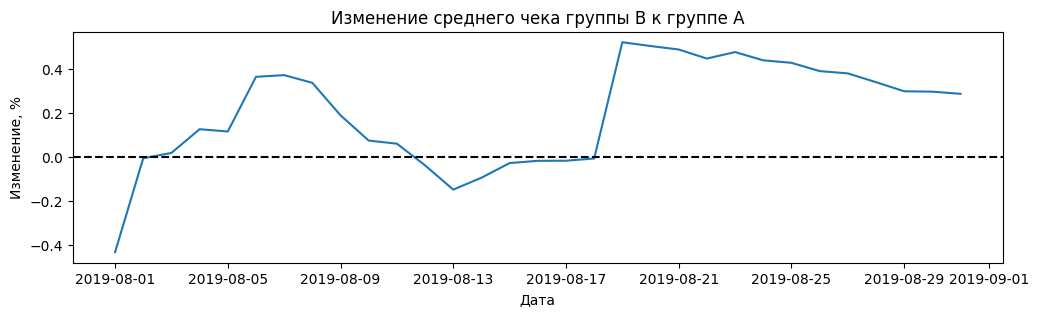

In [36]:
# строим график отношения средних чеков
plt.figure(figsize=(12, 3))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
# добавляем ось Х
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Изменение среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Изменение, %')
plt.show()

**Выводы:**
- График подтверждает, что в группе B есть аномально большой чек.

### График кумулятивного среднего количества заказов на посетителя по группам

In [37]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders'] / cumulativeData['visitors']
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

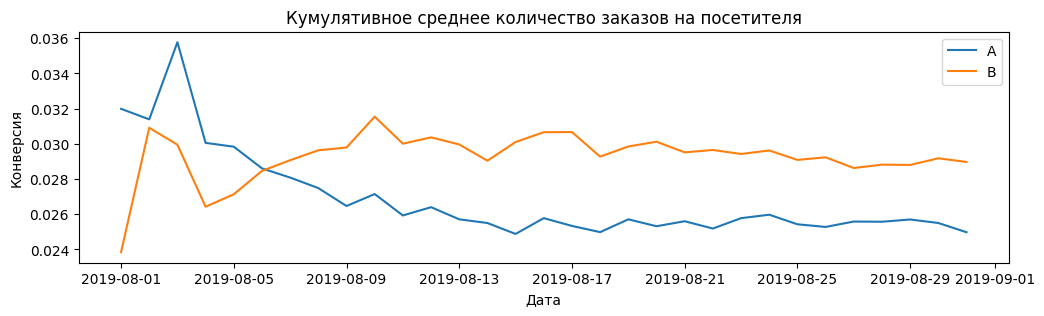

In [38]:
# строим графики кумулятивной средней конверсии
plt.figure(figsize=(12, 3))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('Кумулятивное среднее количество заказов на посетителя')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.show()

**Выводы:**
- На протяжении почти всего теста конверсия группы B выглядит лучше.

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

In [39]:
# собираем даннные в одном датафрейме
mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
    .merge(cumulativeDataB[['date','conversion']],
           left_on='date',
           right_on='date',
           how='left',
           suffixes=['A','B'])

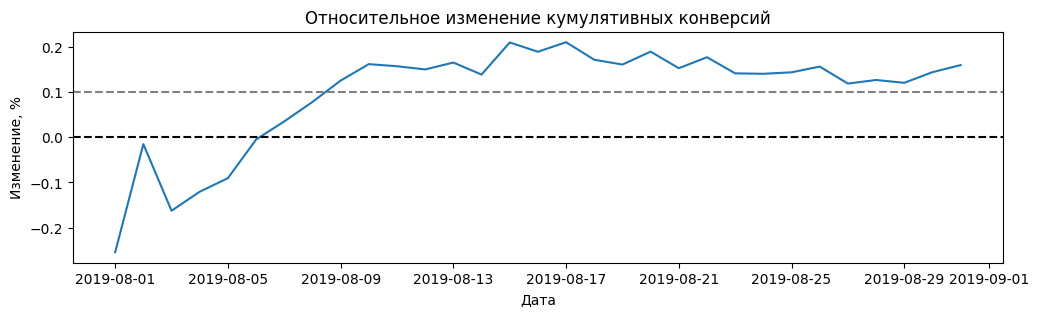

In [40]:
# строим график относительного изменения кумулятивных конверсий
plt.figure(figsize=(12, 3))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label='Относительный прирост конверсии группы B относительно группы A')
plt.title('Относительное изменение кумулятивных конверсий')
plt.xlabel('Дата')
plt.ylabel('Изменение, %')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.show()

**Выводы:**
- В начале теста группа B проигрывала группе A, затем вырвалась вперед и до конца теста была лучше.

### Точечный график количества заказов по пользователям

In [41]:
orders.head()

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B


In [42]:
# считаем количество заказов по пользователям
ordersByUsers = (
    orders.groupby('visitorid', as_index=False)
    .agg({'transactionid' : 'nunique'})
)

In [43]:
# переименовываем колонки
ordersByUsers.columns = ['userId', 'orders']

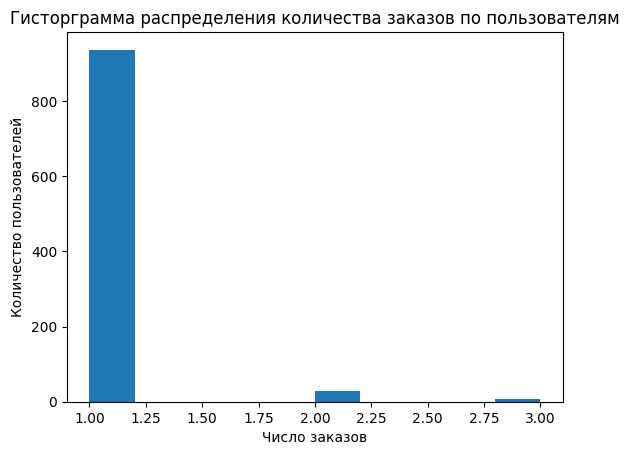

In [44]:
# строим гистограмму
plt.hist(ordersByUsers['orders'])
plt.title('Гисторграмма распределения количества заказов по пользователям')
plt.xlabel('Число заказов')
plt.ylabel('Количество пользователей')
plt.show()

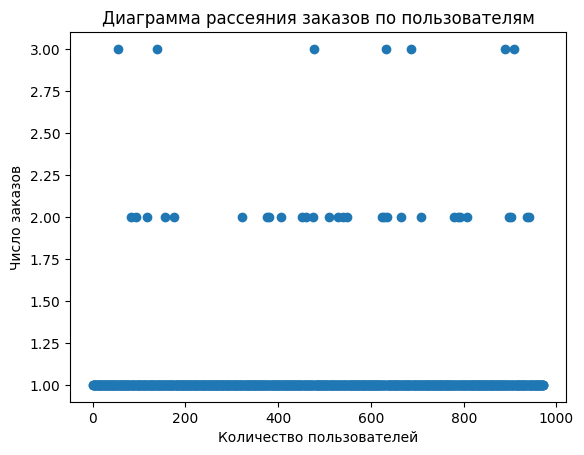

In [45]:
# строим диаграмму рассеяния
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Диаграмма рассеяния заказов по пользователям')
plt.ylabel('Число заказов')
plt.xlabel('Количество пользователей')
plt.show()

**Выводы:**
- Основная часть пользователей делает 1 заказ.

### 95 и 99 перцентили количества заказов на пользователя

In [46]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))
orders_cnt = np.percentile(ordersByUsers['orders'], [95]) # создам переменную для отсеивания слишком большого числа заказов

[1. 2.]


**Выводы:**
- Не более 5% пользователей оформляли более 1 заказа.
- Не более 1% пользователей оформляли более 2 заказов.
- Выберем 2 заказа за верхнюю границу числа заказов и отсеим аномальных пользователей по ней.

### Точечный график стоимостей заказов

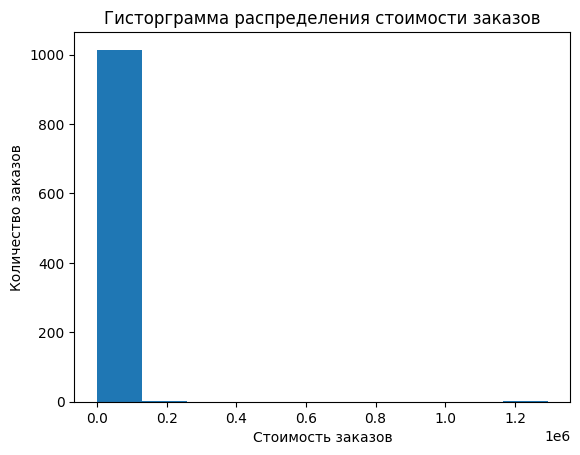

In [47]:
# строим гистограмму распределения стоимости заказов
plt.hist(orders['revenue'])
plt.title('Гисторграмма распределения стоимости заказов')
plt.xlabel('Стоимость заказов')
plt.ylabel('Количество заказов')
plt.show()

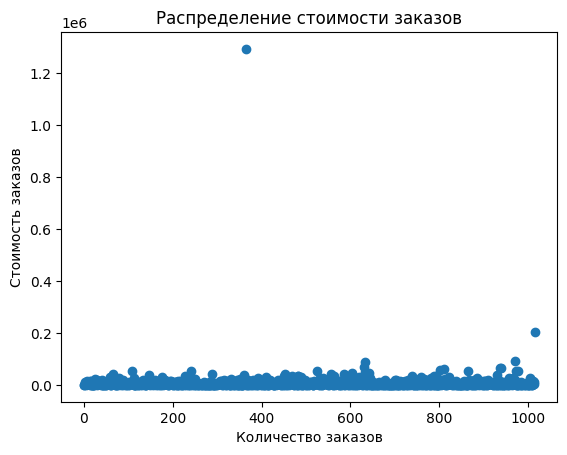

In [48]:
# строим диаграмму рассеяния стоимости заказов
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Распределение стоимости заказов')
plt.ylabel('Стоимость заказов')
plt.xlabel('Количество заказов')
plt.show()

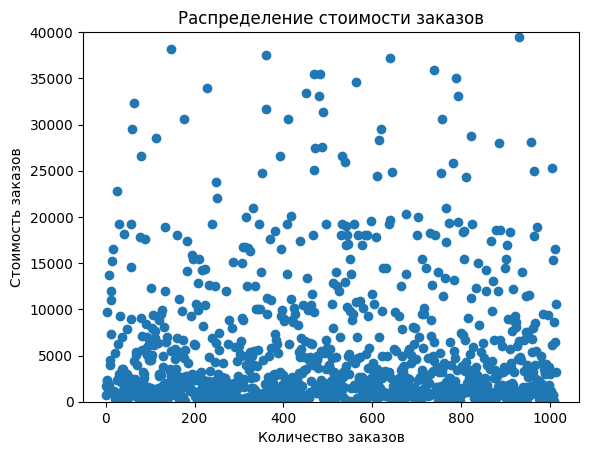

In [49]:
# строим диаграмму рассеяния стоимости заказов
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Распределение стоимости заказов')
plt.ylabel('Стоимость заказов')
plt.xlabel('Количество заказов')
plt.ylim(0, 40000)
plt.show()

**Выводы:**
- Основная часть пользователей делает заказ на сумму от 0 до 0.2. При этом на графике четко видно два заказа, которые вызвали рост кумулятивной выручки и среднего чека.

### 95 и 99 перцентили  стоимости заказов

In [50]:
print(np.percentile(orders['revenue'], [95,99]))
order_sum = np.percentile(orders['revenue'], [95]) # создам переменную с уровнем выручки для отсеивания слишком больших заказов

[26785. 53904.]


**Выводы:**
- Не более 5% пользователей оформляли заказ дороже 26785.
- Не более 1% пользователей оформляли заказ дороже 53904.
- Выберем сумму заказа 26785 в качестве верхней границы и отсемим пользователей по ней.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Воспользуемся критерием Манна-Уитни.<br>
H0: Конверсия в группе A равна конверсии в группе B.<br>
H1: Конверсия в группе A не равна конверсии в группе B.<br>


In [51]:
orders.info()
print()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1016 non-null   int64         
 1   visitorid      1016 non-null   int64         
 2   date           1016 non-null   datetime64[ns]
 3   revenue        1016 non-null   int64         
 4   group          1016 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.6+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [52]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [53]:
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

In [54]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              23           142779              17   
1 2019-08-02              19            91602              23   
2 2019-08-03              24           112473              14   
3 2019-08-04              11            41176              14   
4 2019-08-05              22            86383              21   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0            59758                  23               142779   
1           162043                  42               234381   
2            67049                  66               346854   
3            96890                  77               388030   
4            89908                  99               474413   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  17                59758               719   
1                  40               221801               619   
2                  54               28

In [55]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)

ordersByUsersA.columns = ['visitorid', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique})
)

ordersByUsersB.columns = ['visitorid', 'orders']

sampleA = pd.concat(
    [
            ordersByUsersA['orders'],
            pd.Series(
                0,
                index=np.arange(
                    data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
                ),
                name='orders',
            ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
            ordersByUsersB['orders'],
            pd.Series(
                0,
                index=np.arange(
                    data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
                ),
                name='orders',
            ),
    ],
    axis=0,
)

print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print('Различие средней конверсии между группами:',"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.011
Различие средней конверсии между группами: 0.160


**Вывод:**
- По «сырым» данным статистически значимые различия в конверсиях групп А и B есть. P-value = 0.011, меньше 0.05. Значит отверагем нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет.
- Относительный проигрыш группы B равен 16%.

### Cтатистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Проверим статистическую значимость различий в среднем чеке между группами.<br>
H0: различий в среднем чеке между группами нет.<br>
H1: различия в среднем чеке между группами есть. 

In [56]:
print('p-value:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],
                                          orders[orders['group']=='B']['revenue'])[1]))
print('Относительное различие среднего чека между группами:','{0:.3f}'.format(orders[orders['group']=='B']['revenue']\
               .mean()/orders[orders['group']=='A']['revenue']\
               .mean() -1))

p-value: 0.829
Относительное различие среднего чека между группами: 0.287


**Выводы:**
- P-value значительно больше 0,05, значит статистически значимых отличий в среднем чеке между группами нет.
- При этом относительное различие среднего чека составляет почти 28.7%.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Оставим только тех пользователей, которые делают 1 заказ, а такжее ограничим сумму заказа 26785.

In [57]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > orders_cnt[0]]['visitorid'],
        ordersByUsersB[ordersByUsersB['orders'] > orders_cnt[0]]['visitorid'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > order_sum[0]]['visitorid']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print('Аномальных пользователей:', abnormalUsers.shape[0])

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitorid, dtype: int64
Аномальных пользователей: 86


In [58]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorid'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [59]:
print('p-value:','{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительная разница в конверсии между группами','{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value: 0.016
Относительная разница в конверсии между группами 0.174


**Выводы:**
- P-value меньше 0,05, отвергаем нулевую гипотезу. Группа B значительно лучше группы A.
- При этом относительное различие конверсии составляет 17.4%.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Проверим статистическую значимость различий в среднем чеке между группами по очищенным данным.<br>
H0: различий в среднем чеке между группами нет.<br>
H1: различия в среднем чеке между группами есть. 

In [60]:
print('p-value',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Относительная разница размера чека между группами',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value 0.727
Относительная разница размера чека между группами -0.034


**Выводы:**
- P-value значительно больше 0,05, значит статистически значимых отличий в среднем чеке между группами нет.
- При этом относительное различие среднего чека составляет -3.4%.

[Оглавление](#section_id5)

## Решение по результатам теста
<a id='section_id4'></a>

**Выводы:**
- Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий.
- По сырым данным и очищенным данным нет статистически значимого различия по среднему чеку между группами.

Предлагается остановить тест и зафиксировать победу группы В.

[Оглавление](#section_id5)